In [75]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats as st
from statsmodels.stats.weightstats import *
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

%matplotlib inline 

In [76]:
print("python", sys.version)
print("pandas", pd.__version__)
print("numpy", np.__version__)
print("scipy", scipy.__version__)

python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
pandas 1.1.3
numpy 1.19.2
scipy 1.5.2


# Анализ исторических продаж игр для планирования рекламных кампаний будущих релизов

**План работы**

[Введение](#intro)
1. [Подготовка данных](#precondition)  
    1.1 [Преобразование типов](#type_format)  
    1.2 [Обработка пропусков](#fillna)  
2. [Исследование данных](#data_exploring)  
    2.1 [Распределение количества выпускаемых игр по годам](#games_by_year)  
    2.2 [Распределение суммы продаж по платформам в разрезе времени ](#sales_by_year)  
    2.3 [Диаграмма размаха продаж по актуальным платформам](#boxplots)  
    2.4 [Влияние отзывов на продажи](#reviews_effecting)  
    2.5 [Распределение игр по жанрам](#game_genres)
3. [Портреты пользователей разных регионов](#user_portraits)  
    3.1 [Популярность платформ по регионам](#platforms_popularity)  
    3.2 [Популярность жанров по регионам](#genres_popularity)  
    3.3 [Влияние рейтинга ESRB на продажи](#esrb)  
4. [Исследование статистических показателей](#statistics)  
    4.1 [Проверка гипотезы о равенстве средних пользовательских рейтингов Xbox One и PC](#xonevspc)  
    4.2 [Проверка гипотезы о различии средних пользовательских оценок для жанров Action и Sports](#actionvssports) 
    
[Общие выводы](#final_text)    

# Введение <a id='intro'></a>

В данном исследовании нам предстоит проанализировать исторические данные о продажах игр на разных платформах. 
В нашем распоряжении датасет на ~16000 строк со следующими признаками
- **Name** — название игры
- **Platform** — платформа
- **Year_of_Release** — год выпуска
- **Genre** — жанр игры
- **NA_sales** — продажи в Северной Америке (миллионы долларов)
- **EU_sales** — продажи в Европе (миллионы долларов)
- **JP_sales** — продажи в Японии (миллионы долларов)
- **Other_sales** — продажи в других странах (миллионы долларов)
- **Critic_Score** — оценка критиков (от 0 до 100)
- **User_Score** — оценка пользователей (от 0 до 10)
- **Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Целью исследования** является нахождение закономерностей в данных, влияющих на успешность (объем продаж) игры.

## 1. Подготовка данных <a id='precondition'></a>

In [79]:
df = pd.read_csv('games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Сразу видим, что нужно переименовать столбцы: приведем все названия к нижнему регистру

In [80]:
df.rename(columns={"Name":"name", "Platform":"platform", "Year_of_Release":"year_of_release", "Genre":"genre", "NA_sales":"na_sales", "EU_sales":"eu_sales", "JP_sales":"jp_sales", "Other_sales":"other_sales", "Critic_Score":"critic_score", "User_Score":"user_score", "Rating":"rating"}, inplace=True)
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


###  1.1 Преобразование типов <a id='type_format'></a>

Посмотрим на типы данных в столбцах:

In [81]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 5.6 MB


Предположим, что набор значений в столбцах genre, rating сильно ограничен. Посмотрим на данные:

In [82]:
df.genre.unique(), df.rating.unique()

(array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
        'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
        'Strategy', nan], dtype=object),
 array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object))

Да, значений в столбцах не очень много, можно заменить их типы на category. 
Проведем следующие преобразования типов столбцов:
- **platform**: оставим как есть
- **year_of_release**: float64 заменим тип на uint16. Для хранения года выпуска игры удобнее будет использовать целочисленный неотрицательный тип uint16 - он может хранить в себе значения в диапазоне от 0 до 65535. Помимо того, что обрабатывать год как целое число несколько удобнее, такой заменой уменьшаем и количество памяти, необходимое для хранения этого столбца - каждое значение типа float64 имеет размер 8 байт, когда как uint16 - 2 байта.
- **genre**: object заменим на category
- **rating**: object заменим на category
- **user_score**: object заменим на float16. Зту замену необходимо произвести, так как в столбце хранится оценка пользователей, которая всегда будет иметь числовое значение.

In [83]:
df['genre'] = df['genre'].astype('category')
df['rating'] = df['rating'].astype('category')

Прежде чем заменить тип столбца **year_of_release**, необходимо обработать пропуски в этом столбце. В выводе функции info() выше видим, что в столбце около 200 пропусков. Убедимся, что пропущенные значения не принадлежат какой-то одной из платформ или значению рейтинга ESRB:

In [84]:
def get_grouped_stats(df, group_column, column, func, first_rows=5, ):
    matched_rows = df[func(df[column])].groupby(group_column)['name'].count()
    matched_rows.name = 'matched_rows_count'    
    rows_count = df.groupby(group_column)['name'].count()
    rows_count.name = 'rows_count'
    result = pd.concat([matched_rows, rows_count], axis=1, join='inner')
    result['rate'] = result.matched_rows_count / result.rows_count
    return result.sort_values(by='rate', ascending=False)[:first_rows]

In [85]:
get_grouped_stats(df, 'platform', 'year_of_release', pd.isnull)

,matched_rows_count,rows_count,rate
platform,,,
2600,17,133,0.127820
Wii,34,1320,0.025758
XB,21,824,0.025485
GC,14,556,0.025180
X360,30,1262,0.023772


In [86]:
get_grouped_stats(df, 'rating', 'year_of_release', pd.isnull)

,matched_rows_count,rows_count,rate
rating,,,
RP,2,3,0.666667
E10+,27,1420,0.019014
T,56,2961,0.018913
E,69,3990,0.017293
M,27,1563,0.017274


Если пропущенные в столбце year_of_release распределены практически равномерно по типам платформ, то в отношении столбца с рейтингом есть интересное замечание. Для 2 из 3 записей с рейтингом RP пропущено значение в столбце year_of_release.
Путем поиска в Яндекс узнаем, что RP значит Rating Pending, т.е. рейтинг ожидается. Посмотрим, что это за игры:

In [87]:
df[df.rating == 'RP']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13672,Clockwork Empires,PC,NaN,Strategy,0.0,0.04,0.0,0.00,58.0,3.8,RP
14270,Supreme Ruler: Cold War,PC,2011.0,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP
16180,WRC: FIA World Rally Championship,PC,NaN,Racing,0.0,0.01,0.0,0.00,65.0,NaN,RP


Так как таких строки всего 3, попробуем заполнить данные самостоятельно. Путем поиска на ресурсах [ESRB](https://www.esrb.org/) и [Metacritic](https://www.metacritic.com/) находим следующую информацию:
- **Supreme Ruler: Cold War** [получила](https://www.esrb.org/ratings/31253/Supreme+Ruler+Cold+War/) на ESRB рейтинг E10+
- **WRC: FIA World Rally Championship** [вышла в релиз](https://www.metacritic.com/game/pc/wrc-fia-world-rally-championship) на PC в 2010 году, однако по состоянию на 2021 так и не получила свой уровень рейтинга от ESRB. Можно просто удалить данную запись из таблицы.
- **Clockwork Empires** [вышла в релиз](https://www.metacritic.com/game/pc/clockwork-empires) в 2016 году, но также до сих пор не получила свой рейтинг от ESRB. Также удаляем эту запись, тем самым полностью избавляясь от категории 'RP' в столбце rating

In [88]:
#удаляем ненужные записи
df.drop(df.loc[(df['name']=='WRC: FIA World Rally Championship') & (df['platform']=='PC')].index, inplace=True)
df.drop(df.loc[(df['name']=='Clockwork Empires') & (df['platform']=='PC')].index, inplace=True)

#меняем рейтинг для Supreme Ruler: Cold War
df.loc[df[df.name == 'Supreme Ruler: Cold War'].index, 'rating'] = 'E10+'

#меняем тип столбца rating на category
df.rating.cat.set_categories(df.rating.unique().categories, inplace=True)

In [89]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16711 non-null  object  
 1   platform         16713 non-null  object  
 2   year_of_release  16446 non-null  float64 
 3   genre            16711 non-null  category
 4   na_sales         16713 non-null  float64 
 5   eu_sales         16713 non-null  float64 
 6   jp_sales         16713 non-null  float64 
 7   other_sales      16713 non-null  float64 
 8   critic_score     8135 non-null   float64 
 9   user_score       10013 non-null  object  
 10  rating           9947 non-null   category
dtypes: category(2), float64(6), object(3)
memory usage: 4.6 MB


Видим, что пропуски распределены по разным значениям категориальных переменных. Так как количество пропусков в целом небольшое по сравнению с размером датасета, просто удалим записи с пропущенными значениями в этом столбце. Удалим пропуски и поменяем тип столбца:

In [90]:
#удаляем пропуски в столбце year_of_release
df.dropna(subset=['year_of_release'], inplace=True)
#меняем тип столбца year_of_release на uint16
df['year_of_release'] = df['year_of_release'].astype('uint16')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16446 non-null  object  
 2   year_of_release  16446 non-null  uint16  
 3   genre            16444 non-null  category
 4   na_sales         16446 non-null  float64 
 5   eu_sales         16446 non-null  float64 
 6   jp_sales         16446 non-null  float64 
 7   other_sales      16446 non-null  float64 
 8   critic_score     7983 non-null   float64 
 9   user_score       9839 non-null   object  
 10  rating           9768 non-null   category
dtypes: category(2), float64(5), object(3), uint16(1)
memory usage: 3.8 MB


Помимо большого количества пропусков в столбцах **critic_score**, **user_score**, **rating** остались еще записи с 2 пропусками в столбцах **name** и **genre**. Взглянем на них:

In [91]:
df[df.genre.isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Тоже смело можно удалять:

In [92]:
#удаляем все строки с пропусками в столбцах name и genre
df.dropna(subset=['name', 'genre'], inplace=True)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  object  
 2   year_of_release  16444 non-null  uint16  
 3   genre            16444 non-null  category
 4   na_sales         16444 non-null  float64 
 5   eu_sales         16444 non-null  float64 
 6   jp_sales         16444 non-null  float64 
 7   other_sales      16444 non-null  float64 
 8   critic_score     7983 non-null   float64 
 9   user_score       9839 non-null   object  
 10  rating           9768 non-null   category
dtypes: category(2), float64(5), object(3), uint16(1)
memory usage: 3.8 MB


Дальше необходимо поменять тип в столбце **user_score** на float64, посколько там хранятся оценки пользователей, что явно должно храниться в числовом виде. Однако известно, что в столбце содержатся значения нечислового типа, а именно 'tbd', что означает to be determined, т.е. будет определен в будущем. Посмотрим, сколько таких данных и как они распределены:

In [93]:
df[df['user_score'] == 'tbd'].shape

(2376, 11)

In [94]:
get_grouped_stats(df, 'year_of_release', 'user_score', lambda x: x =='tbd', 10)

,matched_rows_count,rows_count,rate
year_of_release,,,
2009,405,1426,0.284011
2010,331,1255,0.263745
2002,192,829,0.231604
2008,326,1427,0.228451
2011,217,1136,0.191021
2001,82,482,0.170124
2007,192,1197,0.160401
2004,107,762,0.140420
2005,121,939,0.128860


Видно, что таких значений достаточно много. Посмотрим на корреляцию признаков **user_score** и **critic_score**:

In [95]:
df[~df['critic_score'].isnull()]['critic_score'] \
.corr \
(df[(df['user_score'] != 'tbd') & (~df['user_score'].isnull())]['user_score'].astype(float))

0.5796706281932218

Признаки имеют явную корреляцию: чем больше critic_score, тем больше user_score. **Заполним значения 'tbd' в user_score значениями critic_score / 10** и заново посчитаем корреляцию между признаками

In [96]:
df.loc[df[df['user_score'] == 'tbd'].index, 'user_score'] = df[df['user_score'] == 'tbd']['critic_score'] / 10

In [97]:
df[~df['critic_score'].isnull()]['critic_score'] \
.corr \
(df[(df['user_score'] != 'tbd') & (~df['user_score'].isnull())]['user_score'].astype(float))

0.639229523184417

Корреляция увеличилась не сильно, будем считать такое преобразование user_score приемлимым.
Заменим, наконец, тип столбца user_score на float16:

In [98]:
df['user_score'] = df['user_score'].astype('float16')
df['critic_score'] = df['critic_score'].astype('float16')
df['other_sales'] = df['other_sales'].astype('float16')
df['jp_sales'] = df['jp_sales'].astype('float16')
df['eu_sales'] = df['eu_sales'].astype('float16')
df['na_sales'] = df['na_sales'].astype('float16')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  object  
 2   year_of_release  16444 non-null  uint16  
 3   genre            16444 non-null  category
 4   na_sales         16444 non-null  float16 
 5   eu_sales         16444 non-null  float16 
 6   jp_sales         16444 non-null  float16 
 7   other_sales      16444 non-null  float16 
 8   critic_score     7983 non-null   float16 
 9   user_score       8519 non-null   float16 
 10  rating           9768 non-null   category
dtypes: category(2), float16(6), object(2), uint16(1)
memory usage: 1.3+ MB


### 1.2 Обработка пропусков <a id='fillna'></a>

Посмотрим теперь на пропуски в столбцах user_score и critic_score. Найдем количество строк, в которых пропущены значения в обоих столбцах:

In [99]:
df[(df.user_score.isnull()) & (df.critic_score.isnull())].shape

(7892, 11)

Таких строк очень много! Можно было бы попробовать восстановить их, например, линейной регрессией, но про машинное обучение мы еще не слышали ;(, да и качество таких данных было бы очень сомнительным (заполнять оценки пользователей или критиков, неблагодарное занятие, на мой взгляд).

Получен датасет с правильными типами данных и с отсутствующими пропусками. Можно идти дальше

## 2. Исследование данных <a id='data_exploring'></a>

Добавим столбец с суммарными продажами по всем регионам

In [100]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.375000,28.953125,3.769531,8.453125,76.0,8.000000,E,82.500
1,Super Mario Bros.,NES,1985,Platform,29.078125,3.580078,6.808594,0.770020,NaN,NaN,NaN,40.250
2,Mario Kart Wii,Wii,2008,Racing,15.679688,12.757812,3.789062,3.289062,82.0,8.296875,E,35.500
3,Wii Sports Resort,Wii,2009,Sports,15.609375,10.929688,3.279297,2.949219,80.0,8.000000,E,32.750
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.273438,8.890625,10.218750,1.000000,NaN,NaN,NaN,31.375


### 2.1 Распределение количества выпускаемых игр по годам <a id='games_by_year'></a>

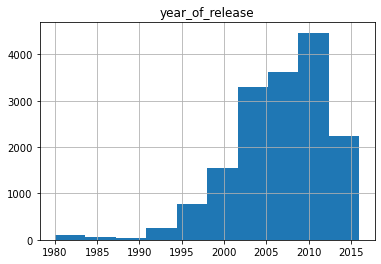

In [101]:
df.hist(column='year_of_release');

Из гистограммы видим, что распределение количества игр имеет левый хвост. Избавимся от хвоста, отсеяв все игры выпущенные до 1998 года

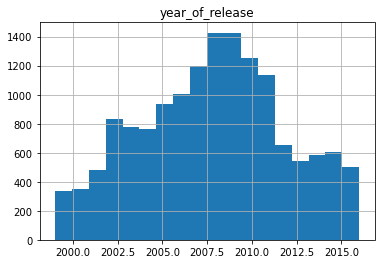

In [102]:
df = df[df['year_of_release'] > 1998]
df.hist(column='year_of_release', bins=df.year_of_release.nunique());

Выводы:
- В последние годы в индустрии наблюдается упадок - количество выпускаемых игр уменьшается. Предполагается, что это последствия глобального кризиса в 2008 году

### 2.2 Распределение суммы продаж по платформам в разрезе времени <a id='sales_by_year'></a>

In [103]:
platforms_grouped = df.groupby('platform')['total_sales'].sum()
platforms_grouped.sort_values(ascending=False)

platform
PS2     1234.000000
X360     961.000000
PS3      931.500000
Wii      891.000000
DS       802.500000
PS4      314.250000
GBA      312.750000
PSP      289.500000
PS       285.250000
3DS      257.750000
XB       251.625000
PC       210.500000
GC       196.750000
XOne     159.250000
N64       95.187500
WiiU      82.187500
GB        67.000000
PSV       53.812500
DC        12.570312
WS         1.419922
SNES       0.260010
SAT        0.090027
Name: total_sales, dtype: float16

In [104]:
def plot_platform_sales_chart(df, figsize=(12,8)):
    legend = []
    years = df.year_of_release.unique()
    platforms = df.platform.unique()
    for platform in platforms:
        legend.append(platform)
        ax = df[df.platform == platform].groupby('year_of_release')['total_sales'].sum().plot(grid=True, figsize=figsize, xticks=years, lw=2)
    ax.legend(legend)

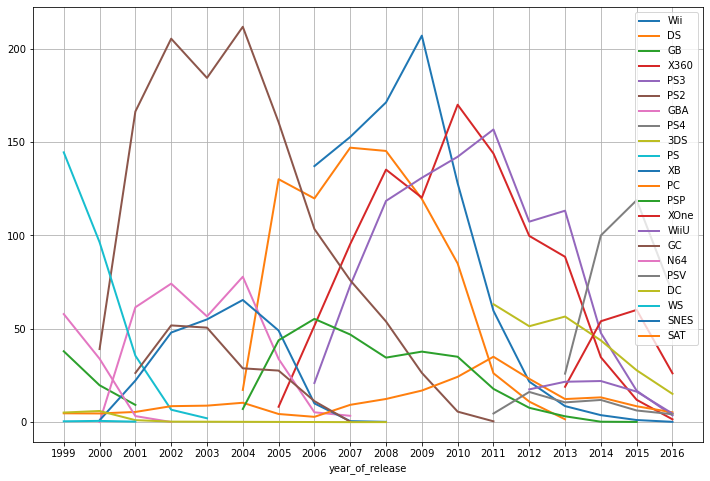

In [105]:
plot_platform_sales_chart(df)

Проанализировав график продаж по платформам в разрезе времени, получаем следующие выводы:
- Игровые платформы "живут" от 6 до 10 лет, однако есть и исключение - PC на протяжении долгого времени (с самого появления и по сей день) остаётся на плаву
- Среди популярных в прошлом платформ выделяются PS2, PS, DS, GBA

Посчитаем среднюю продолжительность "жизни" консоли, т.е. среднее количество лет между годом первой проданной игры и годом последней проданной игры:

In [106]:
df_lifecyclestats = df.groupby('platform')['year_of_release'].agg([lambda x: np.max(x) - np.min(x)]).reset_index()
df_lifecyclestats.rename(columns={"<lambda>":"lifetime_years"}, inplace=True)
df_lifecyclestats.sort_values(by='lifetime_years', ascending=False)

,platform,lifetime_years
7,PC,17
19,X360,11
9,PS2,11
12,PSP,11
17,Wii,10
10,PS3,10
2,DS,9
1,DC,9
20,XB,8
4,GBA,7


Ага, видим выбросы в данных в виде статистики по продолжительности жизни для PC, SNES, SAT. Проанилизируем причины выбросов:

- Причина выброса для **PC** понятна - PC это не игровая платформа, однако на ней тоже выпускаются игры, хоть и в несравнимо меньшем объеме. Уберем эту платформу из расчетов.
- Оставшиеся две платформы **SNES** и **SAT** появились в 1990х. Данные об играх в этот период мы отрезали ранее, поэтому данные платформы также не будем учитывать в расчетах
- Уберем также из расчетов XONe и PS4, поскольку они на момент 2016 года находились только в середине своего жизненного цикла ;)

In [107]:
df_lifecyclestats = df_lifecyclestats[~df_lifecyclestats.platform.isin(['PC', 'XOne', 'PS4', 'SNES', 'SAT'])]
print("Среднее время жизни консоли в годах {} со стандартным отклонением {}".format(df_lifecyclestats.lifetime_years.mean(), df_lifecyclestats.lifetime_years.std()))

Среднее время жизни консоли в годах 6.882352941176471 со стандартным отклонением 3.2381003872096152


Как и на графике, рассчитанная характеристика говорит о том, что консоль в среднем живет около 7 лет, при этом жизненный цикл имеет большое стандартное отклонение, т.е. консоль может с большой вероятностью прожить и 10 лет и 4 года

Посмотрим на распределение платформ в 2016 году по сумме продаж

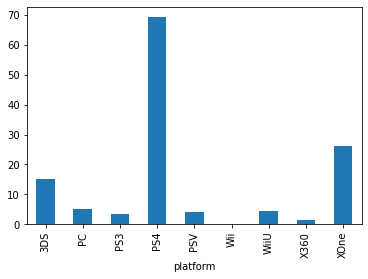

In [108]:
df_2016 = df[df.year_of_release == 2016]
df_2016.groupby('platform')['total_sales'].sum().plot(kind="bar");

Чтобы уменьшить искажение распределения по платформам в данных, посмотрим на самые ранние годы, за которые у нас есть данные по нашим платформам:

In [109]:
df[df.platform.isin(df_2016.platform.unique())] \
.pivot_table(index=['platform'], aggfunc=['min'], values='year_of_release')

,min
,year_of_release
platform,
3DS,2011
PC,1999
PS3,2006
PS4,2013
PSV,2011
Wii,2006
WiiU,2012
X360,2005


Известно, что платформа PC уже давно актуальна, а вот остальные платформы появились в 2011 году и позднее. Далее будем использовать данные начиная с 2011 года.

In [110]:
df_since_2011 = df.loc[df.year_of_release >= 2011].copy()

Посмотрим на данные еще раз, теперь только с 2011 года, а также исключим платформы, у которых уже есть продажи в 2016 году:

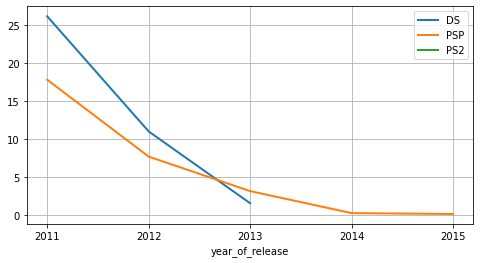

In [111]:
dead_platforms_df = df_since_2011[~df_since_2011.platform.isin(df_2016.platform.unique())]
plot_platform_sales_chart(dead_platforms_df, figsize=(8,4))

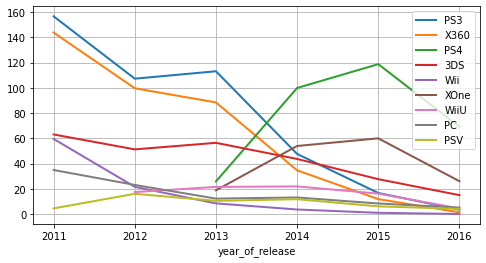

In [112]:
alive_platforms_df = df_since_2011[df_since_2011.platform.isin(df_2016.platform.unique())]
plot_platform_sales_chart(alive_platforms_df, figsize=(8,4))

Из графиков получаем следующую информацию по платформам:
- XOne, PS4 самые актуальные платформы, их продажи на 2016 год упали. Это произошло потому, что у нас неполные данные за 2016 год. В реальности, скорее всего, по состоянию на конец года продажи сильно выросли.
- Продажи DS, PSP, PS2 упали до 0 к 2015 году в связи выходом нового поколения консолей
- К перпспективным платформам на ближайшие годы можно отнести PS4, XOne и PC. Первые две появились недавно и пришли на замену сверхпопулярным PS3 и X360, а PC всегда была актуальна ;)

### 2.3 Диаграмма размаха продаж по актуальным платформам <a id='boxplots'></a>

Построим диаграмму размаха (boxplot) для самый популярных платформ. Сразу огранимичим масштаб, дабы выбросы не мешали анализировать график:

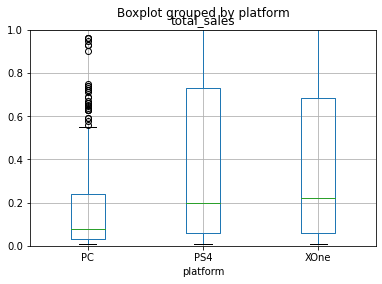

In [113]:
df_since_2011[df_since_2011.platform.isin(['XOne', 'PS4', 'PC'])].boxplot(by='platform', column='total_sales')
plt.ylim(0, 1);

Смотрим на график размаха и делаем выводы:
- В среднем издатели получают больше прибыли от продаж игры на консолях, чем на PC (медиана продаж на консолях больше, а также сам "ящик" шире)
- Большие выбросы в данных присутствуют на всех 3 платформах, это означает что на каждой платформе выходят ААА-проекты, продажи которых уходят далеко за границы продаж "обычных", средних релизов
- Продажи игр на ПК имеют меньший размах из-за процветания пиратства, т.е. многие люди предпочитают скачать взломанную копию игры, нежели покупать лицензионную. Из-за низкого уровня продаж разработчики игр предпочитают либо вообще не выпускать игру на PC

### 2.4 Влияние отзывов на продажи <a id='reviews_effecting'></a>

Исследуем влияние отзывов пользователей и критиков на продажи игр на платформе PS4. Построим scatter plot для признаков user_score и critic_score:

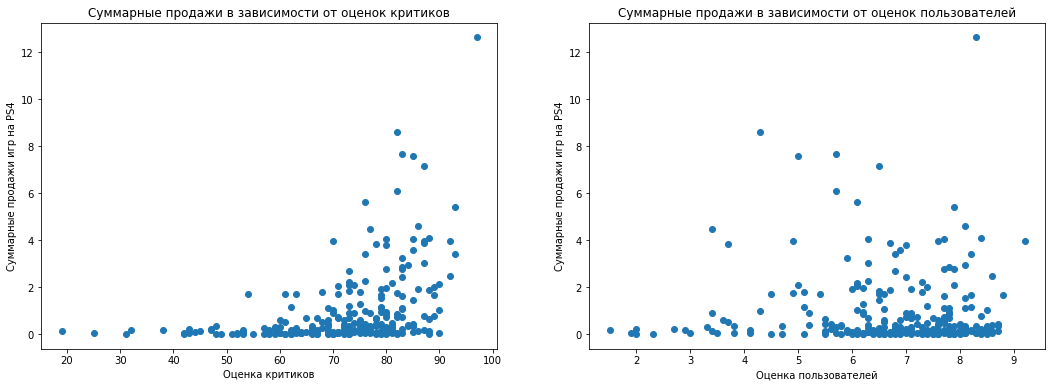

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].scatter(x=df_since_2011[df_since_2011.platform == 'PS4']['critic_score'], y=df_since_2011[df_since_2011.platform == 'PS4']['total_sales'])
axes[0].set_title("Суммарные продажи в зависимости от оценок критиков")
axes[0].set_xlabel("Оценка критиков")
axes[0].set_ylabel("Суммарные продажи игр на PS4")
axes[1].scatter(x=df_since_2011[df_since_2011.platform == 'PS4']['user_score'], y=df_since_2011[df_since_2011.platform == 'PS4']['total_sales'])
axes[1].set_title("Суммарные продажи в зависимости от оценок пользователей")
axes[1].set_xlabel("Оценка пользователей")
axes[1].set_ylabel("Суммарные продажи игр на PS4");

Судя по графику, оценки суммарные продажи сильнее коррелируют с оценками критиков, нежели с оценками пользователей. Посмотрим на корреляции:

In [115]:
df_since_2011[df_since_2011.platform == 'PS4'][['total_sales', 'user_score', 'critic_score']].corr()

,total_sales,user_score,critic_score
total_sales,1.000000,-0.032721,0.406580
user_score,-0.032721,1.000000,0.557469
critic_score,0.406580,0.557469,1.000000


Из матрицы корреляций видим, что присутствует корреляция между оценками критиков и продажами игр

Посмотрим теперь на ту же историю для PC:

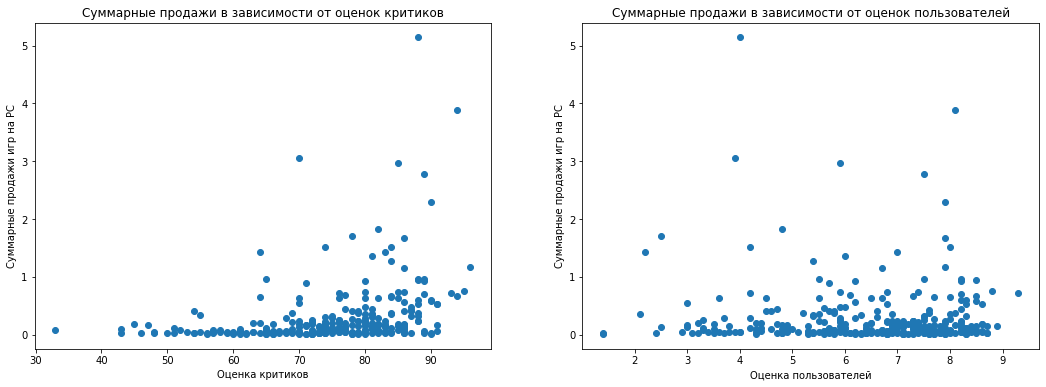

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].scatter(x=df_since_2011[df_since_2011.platform == 'PC']['critic_score'], y=df_since_2011[df_since_2011.platform == 'PC']['total_sales'])
axes[0].set_title("Суммарные продажи в зависимости от оценок критиков")
axes[0].set_xlabel("Оценка критиков")
axes[0].set_ylabel("Суммарные продажи игр на PC")
axes[1].scatter(x=df_since_2011[df_since_2011.platform == 'PC']['user_score'], y=df_since_2011[df_since_2011.platform == 'PC']['total_sales'])
axes[1].set_title("Суммарные продажи в зависимости от оценок пользователей")
axes[1].set_xlabel("Оценка пользователей")
axes[1].set_ylabel("Суммарные продажи игр на PC");

In [117]:
df_since_2011[df_since_2011.platform == 'PC'][['total_sales', 'user_score', 'critic_score']].corr()

,total_sales,user_score,critic_score
total_sales,1.000000,-0.048988,0.314180
user_score,-0.048988,1.000000,0.464761
critic_score,0.314180,0.464761,1.000000


Получаем следующие итоги:
- Между оценками критиков и продажами игр есть заметная корреляция и на PC и на PS4, а вот между оценками пользователей и суммарными продажами она практически нулевая на обеих платформах. Это может быт связано с тем, что критики зачастую получают игру раньше релиза, и могут опубликовать свою оценку игры еще до ее релиза, тем самым предопределив будущие продажи игры

### 2.5 Распределение игр по жанрам <a id='game_genres'></a>

Сгруппируем игры по жанрам и посмотрим на гистограмму:

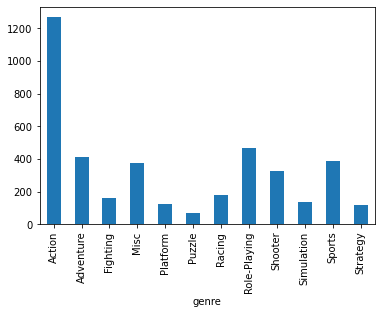

In [118]:
df_since_2011.groupby('genre')['genre'].count().plot(kind='bar');

Больше всего игр имеют жанр Action, меньше всего - Puzzle. Посмотрим на распределение суммарных продаж по жанрам:

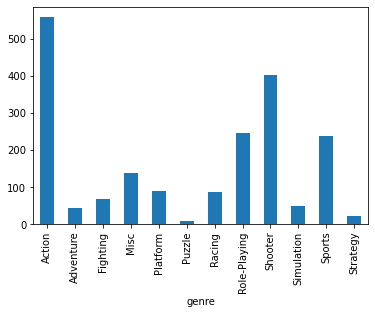

In [119]:
df_since_2011.groupby('genre')['total_sales'].sum().plot(kind='bar');

Из графиков видим следующую информацию:
- Самые прибыльные жанры - Action и Shooter, неплохие продажи имеют игры жанра Sports
- Хуже всего продаются игры жанра Puzzle, Strategy, Adventure

## 3. Портреты пользователей разных регионов <a id='user_portraits'></a>

### 3.1 Популярность платформ по регионам <a id='platforms_popularity'></a>

In [120]:
def get_regional_stats(df, groupby_column):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].set_title("Продажи в Японии")
    axes[1].set_title("Продажи в Северной Америке")
    axes[2].set_title("Продажи в Европе")
    df.groupby(groupby_column)['jp_sales'].sum().sort_values(ascending=False)[:5].plot.bar(ax=axes[0])
    df.groupby(groupby_column)['na_sales'].sum().sort_values(ascending=False)[:5].plot.bar(ax=axes[1])
    df.groupby(groupby_column)['eu_sales'].sum().sort_values(ascending=False)[:5].plot.bar(ax=axes[2])

Посмотрим на самые популярные платформы в разрезе регионов:

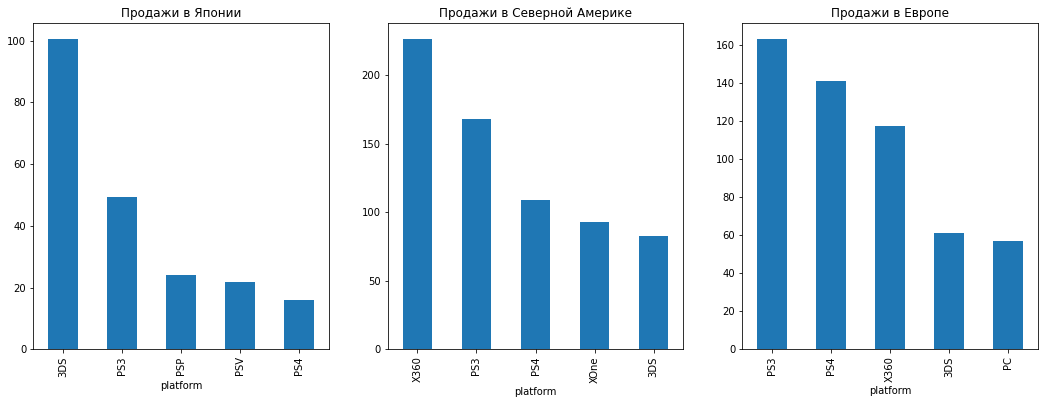

In [121]:
get_regional_stats(df_since_2011, 'platform');

Относительно распределения по платформам в разных регионах можно сделать следующие выводы:
- В США и Японии предпочитают консоли своего производства (X360 и PS3/PS4 соответственно)
- В Японии доминируют консоли от местной компании Sony, а также 3DS, игры на которой в Европе и в США продаются хуже
- В Европе много игр продается на платформе PC, в США и Японии PC не попала в список самых популярных платформ


### 3.2 Популярность жанров по регионам <a id='genres_popularity'></a>

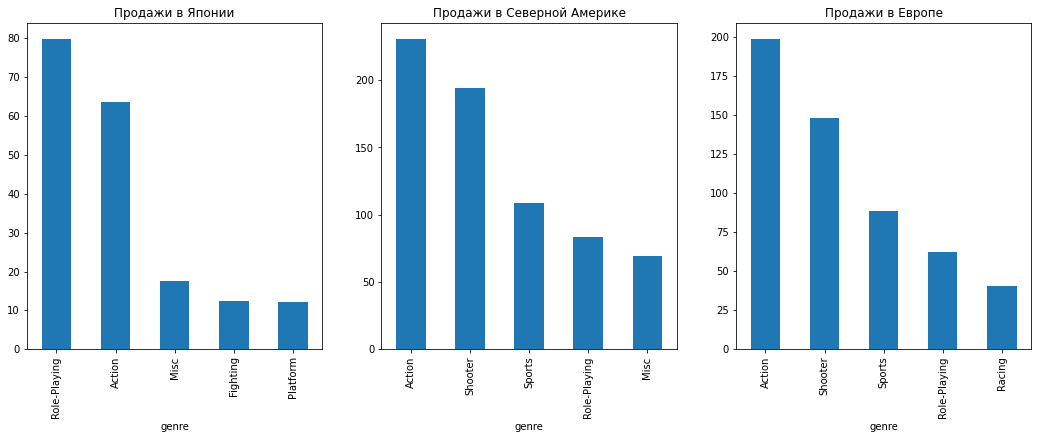

In [122]:
get_regional_stats(df_since_2011, 'genre')

Выводы:
- В Японии больше чем в других регионах популярен жанр RPG (там его и придумали)
- В Японии живут более хардкорные игроки, т.к. среди популярных жанров - платформеры
- В США и Европе жанры распределены по популярности практически одинаково

### 3.3 Влияние рейтинга ESRB на продажи <a id='esrb'></a>

Мы помним, что в столбце rating очень много пропусков. Чтобы графики о влиянии рейтинга на продажи были нагляднее, заполним все пропуски в рейтинге значением "No Rating", чтобы видеть такие записи как отдельную категорию

In [123]:
#добавим новую категорию в переменную
df_since_2011.rating.cat.add_categories('No Rating', inplace=True)

In [124]:
#заполним пропуски
df_since_2011.loc[df_since_2011['rating'].isnull(), 'rating'] = 'No Rating'

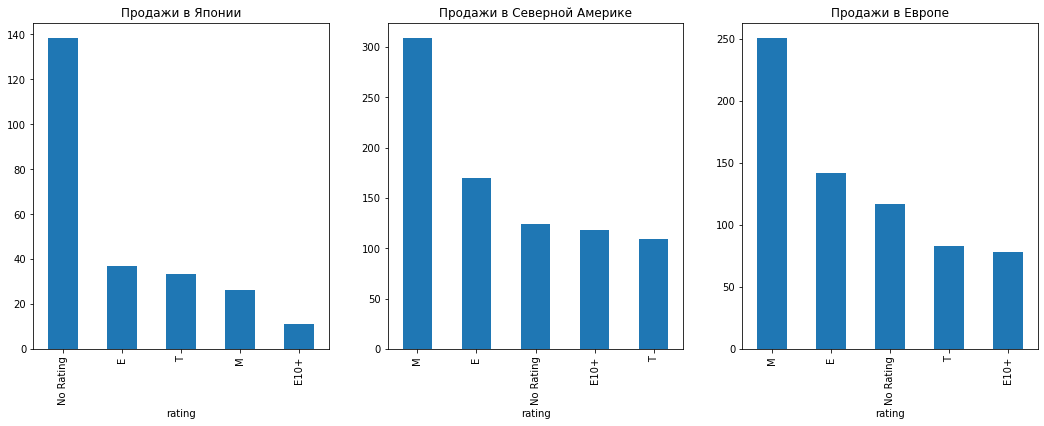

In [125]:
get_regional_stats(df_since_2011, 'rating')

Из графика видно, что:
- Япония отличается от остальных регионов: там лучше всего продаются игры с самым доступным рейтингом (рейтинг E значит Everyone, т.е. подходит всем)
- Большинство игр в Японии не имеют рейтинга. Это может быть связано с тем, что в Японии присвоением возврастных рейтингов контенту занимается CERO, а у нас данные от ESRB

## 4. Исследование статистических показателей <a id='statistics'></a>

Сгруппируем данные по жанрам, посчитаем среднее значение, стандартное отклонение, дисперсию для оценок пользователей и критиков в каждом жанре. Получим сводную таблицу:

In [129]:
genre_stats = df_since_2011.groupby('genre')[['critic_score', 'user_score']].agg([np.mean, np.std, np.var])
genre_stats

critic_score                     user_score                    
                     mean        std      var       mean       std       var
genre                                                                       
Action            69.8750  12.779944  163.375   6.750000  1.349656  1.821289
Adventure         71.9375  11.627009  135.125   7.390625  1.285962  1.653320
Fighting          70.5000  13.221867  174.875   6.871094  1.386292  1.921875
Misc              70.1250  11.067117  122.500   6.785156  1.283948  1.648438
Platform          74.9375  13.107252  171.750   6.972656  1.658177  2.750000
Puzzle            70.0000  10.204574  104.125   6.968750  1.181453  1.395508
Racing            70.9375  13.152699  173.000   6.261719  1.629443  2.654297
Role-Playing      73.5625  11.992778  143.875   7.261719  1.230730  1.514648
Shooter           73.0625  13.065541  170.750   6.417969  1.552892  2.412109
Simulation        63.9375  13.171108  173.500   6.191406  1.742982  3.037109
Sports            72.0000  15.448093  238.625   5.636719  1.680134  2.822266
Strategy          72.6875  12.936171  167.375   6.421875  1.830985  3.351562

Для более наглядного отображения построим гистограммы:

In [130]:
def get_genre_histograms(df):
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))
    genres = list(df_since_2011.genre.unique())
    for i, genre in enumerate(genres):
        df[df['genre'] == genre]['user_score'].hist(ax=axes[i // 3, i % 3])
        df[df['genre'] == genre]['critic_score_scaled'].hist(ax=axes[i // 3, i % 3], alpha=0.5)
        axes[i // 3, i % 3].set_title(genre)
        axes[i // 3, i % 3].legend(['user_score', 'critic_score'])

Для того чтобы совместить гистограммы оценок пользователей и критиков, приведем их к одному масштабу. Для этого создаздим новый столбец critic_score_scaled, в котором сохраним значения critic_score / 10

In [131]:
df_since_2011['critic_score_scaled'] = df_since_2011['critic_score'] / 10

Теперь можно строить наглядные гистограммы:

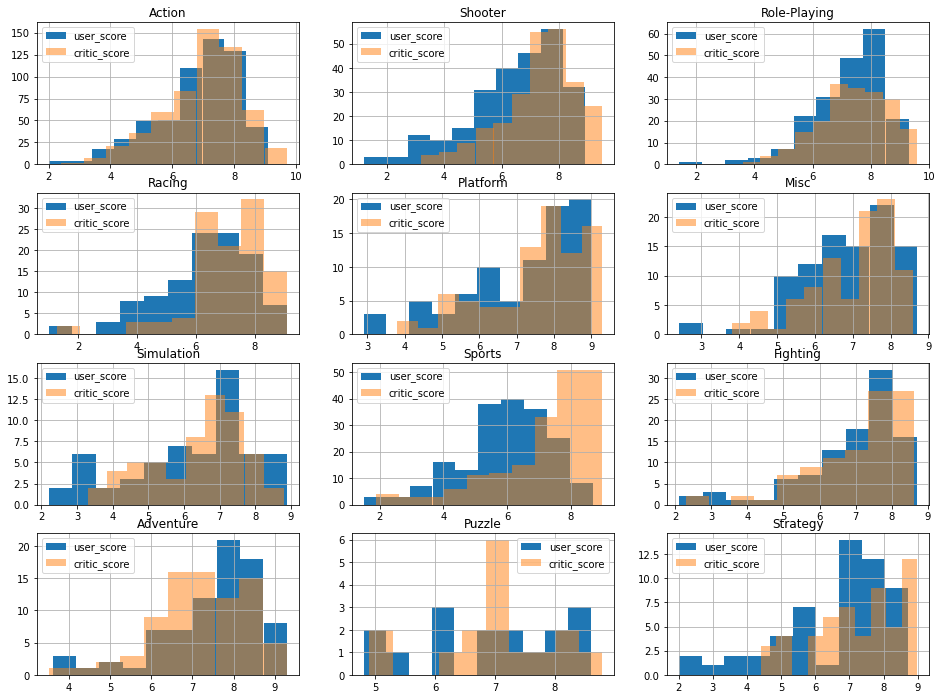

In [132]:
get_genre_histograms(df_since_2011.dropna())

Проанилизировав гистограммы и сводную таблицу делаем выводы:
- Оценки пользователей и критиков по жанрам имеют распределение близкое к равномерному, в случае с оценками пользователей среднее значение равняется 7, оценки критиков в среднем стремятся к 70 из 100 баллов
- В целом оценки пользователей и критиков распределены похожим образом
- Наибольшее различие оценок пользователей наблюдается в жанре **Sports**. В среднем критики более высоко оценивают игры этого жанра, чем пользователи. Это заметно как на графиках, так и в сводной таблице
- Заметно также различие в оценках жанра **Adventure**. Здесь ситуация обратная - критики оценивают игры этого жанра менее высоко, чем пользователи. Может быть, критики просто не любят казуальные игры? ;(
- Пользователи чаще ставят низкие оценки, чем критики (на гистограммах выделяются синие левые хвосты). Может быть, это связано с тем, что критики очень редко ставят низкие оценки игре, т.к. для этого игра должна быть действительно отвратительной. Пользователи же могут занизить оценку игре просто потому что, например, разработчики ввели в игру микротранзакции (платный контент), выкатили обновление добавляющее дизбаланс классов (для игр жанра RPG)

### 4.1 Проверка гипотезы о равенстве средних пользовательских рейтингов Xbox One и PC <a id='xonevspc'></a>

Проверим гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Для начала получим нужные выборки

In [133]:
xone_user_ratings = df_since_2011[df_since_2011.platform == 'XOne']['user_score'].dropna()
pc_user_ratings = df_since_2011[df_since_2011.platform == 'PC']['user_score'].dropna()
pc_user_ratings.name = 'pc'
xone_user_ratings.name = 'xone'
print('Количество оценок PC %s, количество оценок XOne %s' % (pc_user_ratings.shape[0], xone_user_ratings.shape[0]))

Количество оценок PC 307, количество оценок XOne 185


Перед нами задача проверить гипотезу о равенстве средних двух генеральных совокупностей. Посмотрим на диаграммы размаха и гистограммы:

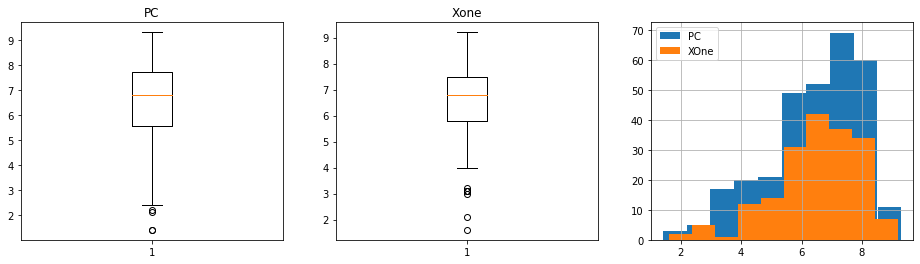

In [134]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].boxplot(pc_user_ratings.values)
ax[0].set_title("PC")
ax[1].boxplot(xone_user_ratings.values)
ax[1].set_title("Xone")
ax[2] = pc_user_ratings.hist(ax=ax[2], label="PC")
ax[2] = xone_user_ratings.hist(ax=ax[2], label="XOne");
ax[2].legend();

Видим, что диаграммы размаха очень похожи, медианные значения пересекаются внутри интеквартильных размахов. Можно предположить, что пользовательские рейтинги не отличаются. Для того чтобы сделать это с помощью статистики, можно воспользоваться t-критерием Стьюдента

t-критерий Стьюдента выбираем из предположения о том, что выборки взяты из нормальных распределений, дисперсия которых неизвестна. На гистограмме выше видим, что оба распределения немного скошены влево. Проверим нормальность распределений визуально с помощью probplot:

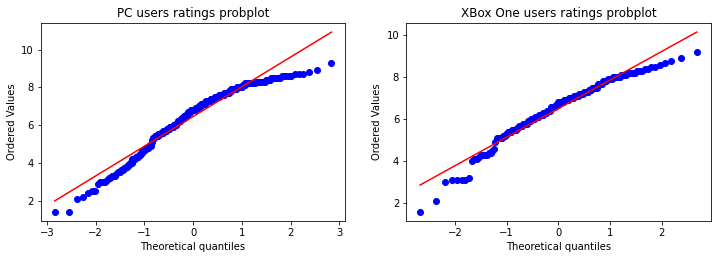

In [135]:
plt.figure(figsize=(12,8))
ax = plt.subplot(2,2,1)
stats.probplot(pc_user_ratings, dist="norm", plot=ax)
ax.set_title("PC users ratings probplot")
ax = plt.subplot(2,2,2)
stats.probplot(xone_user_ratings, dist="norm", plot=ax)
ax.set_title("XBox One users ratings probplot")
plt.show()

На probplot для оценок PC заметны отклонения от нормальности. Однако мы имеем дело с достаточно большими выборками (259 и 161 элемент), что позволяет нам в некоторой степени пренебречь отклонениями от нормального распределения у выборок.

Необходимо также проверить гипотезу о равенстве дисперсий в генеральных совокупностях. Посмотрим на выборочные дисперсии:

In [136]:
pc_user_ratings.var(), xone_user_ratings.var()

(2.596, 1.899)

Выборочные дисперсии довольно сильно отличаются. Применим критерий Левена для проверки гипотезы о равенстве дисперсий двух генеральных совокупностей по их выборкам:

Сформулируем гипотезы, использовать критерий будем с уровнем значимости $\alpha$ = 0.05

$H_0\colon$ истинные дисперсии средних оценок на платформе XOne и PC одинаковы

$H_1\colon$ истинные дисперсии средних оценок на платформе XOne и PC различны

In [137]:
stats.levene(pc_user_ratings.values, xone_user_ratings.values)

LeveneResult(statistic=5.652579678066735, pvalue=0.017812482625947354)

**Отвергаем нулевую гипотезу о равенстве дисперсий в выборках**! Значит в t-тесте необходимо использовать параметр 
> `equal_var = False`


Воспользуемся t-критерием Стьюдента для двух независимых выборок с $\alpha$ = 0.05. Соответствующие гипотезы:

$H_0\colon$ средние значения оценок пользователей для игр на ПК и Xbox One одинаковы

$H_1\colon$ средние значения оценок пользователей для игр на ПК и Xbox One не одинаковы.

In [138]:
stats.ttest_ind(pc_user_ratings.values, xone_user_ratings.values, equal_var = False)

Ttest_indResult(statistic=-0.4282262575566354, pvalue=0.6686985370601637)

Получили p-value > 0.05, **нет оснований отвергать нулевую гипотезу**.

### 4.2 Проверка гипотезы о различии средних пользовательских оценок для жанров Action и Sports <a id='actionvssports'>

Аналогично предыдущему пункту, сначала получим нужные выборки

In [139]:
action_user_ratings = df_since_2011[df_since_2011.genre == 'Action']['user_score'].dropna()
sports_user_ratings = df_since_2011[df_since_2011.genre == 'Sports']['user_score'].dropna()
action_user_ratings.name = 'action'
sports_user_ratings.name = 'sports'
print('Количество оценок в жанре Action %s, количество оценок в жанре Sports %s' % (action_user_ratings.shape[0], sports_user_ratings.shape[0]))

Количество оценок в жанре Action 679, количество оценок в жанре Sports 253


Посмотрим на диаграммы размаха и гистограммы:

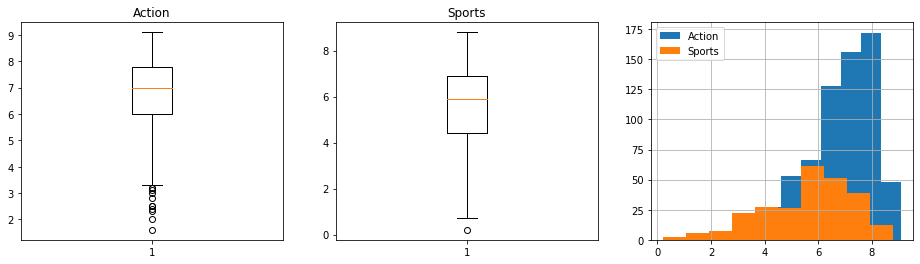

In [140]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].boxplot(action_user_ratings.values)
ax[0].set_title("Action")
ax[1].boxplot(sports_user_ratings.values)
ax[1].set_title("Sports")
ax[2] = action_user_ratings.hist(ax=ax[2], label="Action")
ax[2] = sports_user_ratings.hist(ax=ax[2], label="Sports");
ax[2].legend();

Из диаграмм размаха видим, что медианные значения для оценок различны. Для Action это около 7, а для Sports - ближе к 6. Делаем предположение, что средние оценки действительно различны. Посмотрим на probplot для выборок:

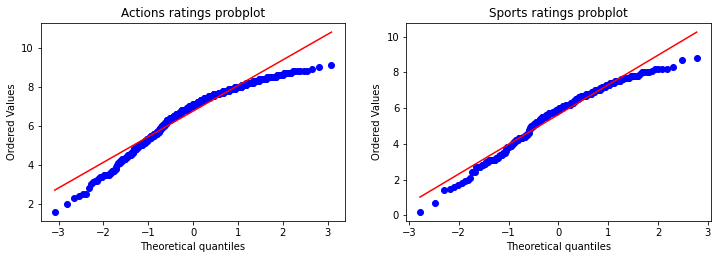

In [141]:
plt.figure(figsize=(12,8))
ax = plt.subplot(2,2,1)
stats.probplot(action_user_ratings, dist="norm", plot=ax)
ax.set_title("Actions ratings probplot")
ax = plt.subplot(2,2,2)
stats.probplot(sports_user_ratings, dist="norm", plot=ax)
ax.set_title("Sports ratings probplot")
plt.show()

Прежде чем проверять гипотезу о равенстве средних оценок с помощью t-теста, помимо проверки на нормальность распределения выборок, необходимо поближе взглянуть на дисперсии двух выборок. 

In [142]:
action_user_ratings.var(), sports_user_ratings.var()

(1.821, 2.824)

Выборочные дисперсии довольно сильно отличаются. Применим критерий Левена для проверки гипотезы о равенстве дисперсий двух генеральных совокупностей по их выборкам:

Сформулируем гипотезы, использовать критерий будем с уровнем значимости $\alpha$ = 0.05

$H_0\colon$ истинные дисперсии средних оценок для игр жанров Action и Sports одинаковы

$H_1\colon$ истинные дисперсии средних оценок для игр жанров Action и Sports различны

In [143]:
stats.levene(action_user_ratings.values, sports_user_ratings.values)

LeveneResult(statistic=17.228714249196358, pvalue=3.618071680793493e-05)

**Отвергаем нулевую гипотезу о равенстве дисперсий в выборках**! Значит в t-тесте необходимо использовать параметр 
> `equal_var = False`


Аналогично предыдущему пункту, воспользуемся t-критерием Стьюдента для двух независимых выборок. Исследуемые выборки имеют распределения, отличающиеся от нормальных, однако учитывая размер выборок можно считать эти отличия несущественным

Сформулируем гипотезы, использовать критерий будем с уровнем значимости $\alpha$ = 0.05

$H_0\colon$ средние значения оценок пользователей для игр в жанре Action и Sports одинаковы

$H_1\colon$ средние значения оценок пользователей для игр в жанре Action и Sports не одинаковы

In [144]:
stats.ttest_ind(action_user_ratings.values, sports_user_ratings.values, equal_var = False)

Ttest_indResult(statistic=9.461386736174079, pvalue=3.2673319177470656e-19)

Получили практически нулевой уровень значимости, **отвергаем нулевую гипотезу** в пользу альтернативной. То есть **оценки пользователей в жанрах Actions и Sports значимо отличаются.**

# Общие выводы <a id='final_text'>

В результате проведения исследования были выявлены некоторые закономерности, влияющие на уровень продаж игр.

После первичного анализа становится ясно, что на начиная примерно **с 2009 года индустрия начала испытывать кризис** - произошел упадок суммарных продаж. 

Построив график зависимости продаж игр по платформам от времени определили, что **среднее время жизненного цикла консоли составляет 7 лет** со стандартным отклонением 3 года. 


Путем анализа данных за 2016 определили **самые актуальные платформы - XOne, PS4 и PC**. Первые две пришли на смену своим сверхпопулярным родителям, а PC традиционно имеет неплохую долю продаж.


Из данных выявили влияние оценок критиков на продажи игры: корреляция между этими признаками составила примерно 0.4 для PC и XOne. Интересно, что **оценки пользователей никак не коррелируют с продажами игр** (корреляция равна 0).


Из диаграмм размаха для популярных платформ отметили, что медианные продажи XOne и PS4 выше чем на PC. То есть выпускать игры на игровых консолях перспективнее, чем на PC.
**Самые популярные и продающиеся жанры независимо от платформы - Action и Shooter**. Самые непопулярные - Puzzle, Strategy и Adventure.

Составлен портрет игрока из разных регионов - Японии, Северной Америки и Европы. В стране восходящего солнца предпочтение практически всегда отдают консолям от Sony, пользователи в Северной Америке любят и Play Station, и Xbox. Самые непривередливые игроки в Европе - там играют даже на  ПК. Из интересных особенностей - **в Японии очень популярен жанр Role Playing, в остальных регионах самые популярные жанры - Action и Shooter**.

Полезная информация извлечена из оценок критиков и пользователей. Чаще всего их оценки совпадают, однако пользователи больше любят ставить экстремально низкие оценки. Но это не страшно - их оценки практически не влияют на продажи игры. 

Проверены гипотеза о равенстве средних оценок на ПК и XOne: статистика говорит, что нет оснований утверждать что они отличаются. А вот оценки пользователей для жанров Sports и Action статистически значимо различаются.

Исходя из результатов анализа можно определить некий "секрет успеха" для игр в 2016 году и позднее: 

- Игра достигнет наибольшего успеха если будет выпущена на самых популярных платформах: PS4, XOne, PC
- Рейтинг игры должен быть E или T (одни из самых доступных рейтингов для людей любого возвраста)
- Игра должна быть в жанре Action, Shooter либо RPG